# Extracción de características

In [ ]:
%pip install --force-reinstall -r requirements.txt

In [2]:
import numpy as np
import cv2
import os
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from skimage import io, color
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import random
import matplotlib.image as mpimg

## Configuration constants

In [3]:
BASE_DIR = "weather"
IMAGE_SIZE = (224,224)
D_RESTNET = 2048 # Dimensionality of ResNet50 features
D_HSV = 512 # Dimensionality of HSV histogram features
D_TOTAL = D_RESTNET + D_HSV

## Extractores base

### CNN

In [4]:
# Initialize the CNN model for feature extraction
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
cnn_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def get_cnn_features(path):
    """
    Extracts features from an image using a pre-trained CNN.

    :param path: file path to the image.
    :type path: str
    :return: numpy array of CNN features.
    :rtype: numpy.ndarray or None
    """
    try:
        img = image.load_img(path, target_size=IMAGE_SIZE)
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) 

        features = cnn_extractor.predict(x, verbose=0).flatten()
        return features

    except Exception as e:
        print(f"Error en CNN con {path}: {e}")
        return None

### HSV

In [5]:
def get_hsv_features(path):
    """
    Calculates the 3D histogram as features for an image.

    The histogram is computed with 8 bins for each channel.

    :param path: file path to the image.
    :type path: str
    :return: numpy array of HSV histogram features.
    :rtype: numpy.ndarray or None
    """
    try:
        # Load image
        img = cv2.imread(path)
        # Resize the image
        img = cv2.resize(img, IMAGE_SIZE)
        # Convert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Calculate the histogram
        hist = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0, 180, 0, 256, 0, 256])
        # Normalize the histogram
        cv2.normalize(hist, hist)
        # Flatten the histogram into a 1D feature vector
        return hist.flatten()

    except Exception:
        return None

### LBP

In [6]:
# LBP configuration constants
RADIUS = 3
N_POINTS = 8*RADIUS
METHOD = "uniform"
D_LBP = N_POINTS + 2

def get_lbp_features(path):
    """
    Extracts LBP features from an image.

    The LBP histogram is computed using the uniform method with a specified radius.

    :param path: file path to the image.
    :type path: str
    :return: numpy array of normalized LBP features.
    :rtype: numpy.ndarray or None
    """
    try:
        # Load image and resize
        img = cv2.imread(path)
        img = cv2.resize(img, IMAGE_SIZE)

        # Convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculate LBP matrix
        lbp_matrix = local_binary_pattern(img, N_POINTS, RADIUS, method=METHOD)

        # Calculate the histogram of LBP patterns
        # The number of bins is determined by the max LBP value + 1
        n_bins = int(lbp_matrix.max() + 1)
        hist, _ = np.histogram(lbp_matrix.ravel(),
                               bins=n_bins,
                               range=(0,n_bins))

        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7) # Add a small epsilon to prevent division by zero

        # Return the feature vector
        return hist

    except Exception:
        return None

## Extractores

In [7]:
def generate_matrix(dir, subset, extractors):
    """
    Generates a feature matrix by combining features from the specified
    extractors for all images in a dataset subset.

    Features for each image are concatenated and L2-normalized.

    :param dir: base directory of the dataset.
    :type dir: str
    :param subset: subset of the dataset to process.
    :type subset: str
    :param extractors: list of extractor names to use.
    :type extractors: list[str]
    :return: tuple of numpy arrays containing the feature matrix and image paths.
    :rtype: tuple[numpy.ndarray, numpy.ndarray]
    """
    feature_list = []
    image_paths = []

    extractor_map = {
        "CNN": get_cnn_features,
        "HSV": get_hsv_features,
        "LBP": get_lbp_features
    }

    # Validate all requested extractors exist in the map
    for ext in extractors:
        if ext not in extractors:
            raise ValueError(f"Invalid extractor.")

    # Iterate through class directories
    for class_name in os.listdir(dir):
        class_path = os.path.join(dir, class_name)
        if os.path.isdir(class_path):
            subset_path = os.path.join(class_path, subset)
            if os.path.isdir(subset_path):
                print(f"Processing class {class_name} in subset {subset}.")

            # Iterate through images in the subset directory
            for img_name in tqdm(os.listdir(subset_path), desc=f"Class {class_name} ({subset})"):
                # Check for common image file extensions
                if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(subset_path, img_name)

                    current_features = []
                    all_present = True

                    # Extract features using all specified extractors
                    for ext_name in extractors:
                        extractor = extractor_map[ext_name]
                        features = extractor(img_path)

                        if features is not None:
                            current_features.append(features)
                        else:
                            # Stop and discard image if any feature extraction fails
                            all_present = False
                            break

                    if all_present and current_features:
                        # Concatenate the features from all extractors
                        final_features = np.concatenate(current_features).astype("float32")

                        # L2-normalize the final concatenated feature vector
                        faiss.normalize_L2(final_features.reshape(1, -1))

                        feature_list.append(final_features)
                        image_paths.append(img_path)

    if not feature_list:
        print(f"Feature extraction failed, matrix is empty.")
        return np.array([]), np.array([])

    feature_matrix = np.array(feature_list)
    print(f"Final feature matrix size: {feature_matrix.shape}")

    return feature_matrix, np.array(image_paths)


# Índice FAISS

In [8]:
def FAISS_index(feature_matrix, paths, index_name):
    """
    Creates a flat FAISS index and saves it along with the features and paths.

    :param feature_matrix: numpy array of features.
    :type feature_matrix: numpy.ndarray
    :param paths: numpy array of image paths.
    :type paths: numpy.ndarray
    :param index_name: name of the index.
    """
    if feature_matrix.size == 0:
        print(f"Empty matrix provided for indexing.")
        return

    # Feature vector dimensionality
    d = feature_matrix.shape[1]

    # Create a brute-force L2 distance index
    index = faiss.IndexFlatL2(d)

    # Add vectors to the index
    index.add(feature_matrix)

    # Save the index and supporting data
    faiss.write_index(index, f"faiss_index_{index_name}.bin")
    np.save(f"features_{index_name}.npy", feature_matrix)
    np.save(f"paths_{index_name}.npy", paths)

    print(f"Flatt indexing {index_name} completed.\n Total images indexed: {index.ntotal}")

In [9]:
def FAISS_index_ivf(feature_matrix, paths, index_name, nlist=10):
    """
    Creates an IVF FAISS index and saves it along with the features and paths.

    :param feature_matrix: numpy array of features.
    :type feature_matrix: numpy.ndarray
    :param paths: numpy array of image paths.
    :type paths: numpy.ndarray
    :param index_name: name of the index.
    :type index_name: str
    :param nlist: number of clusters.
    :type nlist: int
    """
    if feature_matrix.size == 0:
        print(f"Empty matrix provided for IVF indexing.")
        return

    d = feature_matrix.shape[1]
    n_data = feature_matrix.shape[0]

    # Use a flat index as the quantizer for the IVF index
    quantizer = faiss.IndexFlatL2(d)

    # Dynamically determine number of clusters based on the number of data points
    nlist = int(np.sqrt(n_data))
    if nlist < 10:
      nlist = 10

    # Create the IndexIVFFFlat index with L2 metric
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

    # Clusters the vectors to build the inverted lists
    index.train(feature_matrix)

    # Add vectors to the trained
    index.add(feature_matrix)

    # Save the index and supoorting data
    faiss.write_index(index, f"faiss_index_{index_name}.bin")
    np.save(f"features_{index_name}.npy", feature_matrix)
    np.save(f"paths_{index_name}.npy", paths)

    print(f"IVF Indexing {index_name} completed.\n Total images indexed: {index.ntotal}.\n Clusters: {nlist}")

In [10]:
def load_FAISS_index(index_name):
  """
  Loads a saved FAISS index, feature matrix, and image paths from disk.

  :param index_name: the name used to save the index files.
  :type index_name: str
  :return: a tuple containing the loaded index, feature matrix, and image paths.
  :rtype: tuple[faiss.Index, numpy.ndarray, numpy.ndarray] or tuple[None, None, None]
  """
  try:
    # Load the FAISS index structure
    index = faiss.read_index(f"faiss_index_{index_name}.bin")
    # Load the feature matrix
    feature_matrix = np.load(f"features_{index_name}.npy")
    # Load the image paths
    paths = np.load(f"paths_{index_name}.npy")

    return index, feature_matrix, paths

  except Exception as e:
    print(f"Error loading index {index_name}: {e}")
    return None, None, None

In [11]:
def search_image(query_path, k, index, paths, extractors):
  """
  Performs a nearest neighbor search for a query image against the FAISS index.

  The query image's features are extracted, concatenated, L2-normalized, and
  then used to query the index.

  :param query_path: file path to the query image.
  :type query_path: str
  :param k: number of nearest neighbors to retrieve.
  :type k: int
  :param index: the FAISS index to search.
  :type index: faiss.Index
  :param paths: numpy array of image paths.
  :type paths: numpy.ndarray
  :param extractors: list of extractor names to use.
  :type extractors: list[str]
  :return: a tuple containing the distances and indices of the nearest neighbors.
  :rtype: tuple
  """
  extractor_map = {
      "CNN": get_cnn_features,
      "HSV": get_hsv_features,
      "LBP": get_lbp_features
  }

  # Validate extractors
  for ext in extractors:
    if ext not in extractor_map:
      raise ValueError(f"Extractor no válido.")

  current_features = []

  # Extract features for the query image
  for ext in extractors:
    features = extractor_map[ext](query_path)
    if features is not None:
      current_features.append(features)
    else:
      return [], []

  # Concatenate features and prepare the query vector
  query_vector = np.concatenate(current_features).astype("float32").reshape(1,-1)

  # L2-normalize the query vector
  faiss.normalize_L2(query_vector)

  # Solo si se usa IVF
  # index.nprobe = 5
  # Perform the search
  distances, indices = index.search(query_vector, k)

  # Return distances and corresponding image paths
  return distances[0], paths[indices[0]]

# Train

In [36]:
if __name__ == "__main__":
    # Matriz generation
    feature_matrix1, paths1 = generate_matrix(BASE_DIR, "train", ["CNN", "HSV"])
    feature_matrix2, paths2 = generate_matrix(BASE_DIR, "train", ["CNN", "LBP"])
    feature_matrix3, paths3 = generate_matrix(BASE_DIR, "train", ["CNN", "HSV", "LBP"])

    # FAISS indexation
    FAISS_index(feature_matrix1, paths1, "CNN_HSV")
    FAISS_index(feature_matrix2, paths2, "CNN_LBP")
    FAISS_index(feature_matrix3, paths3, "CNN_HSV_LBP")

    print("Proceso completado")

Processing class dew in subset train.


Class dew (train): 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Processing class fogsmog in subset train.


Class fogsmog (train): 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Processing class frost in subset train.


Class frost (train): 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


Processing class glaze in subset train.


Class glaze (train): 100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


Processing class hail in subset train.


Class hail (train): 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


Processing class lightning in subset train.


Class lightning (train): 100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Processing class rain in subset train.


Class rain (train): 100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


Processing class rainbow in subset train.


Class rainbow (train): 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


Processing class rime in subset train.


Class rime (train): 100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


Processing class sandstorm in subset train.


Class sandstorm (train): 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Processing class snow in subset train.


Class snow (train): 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Final feature matrix size: (1100, 2560)
Processing class dew in subset train.


Class dew (train): 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


Processing class fogsmog in subset train.


Class fogsmog (train): 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Processing class frost in subset train.


Class frost (train): 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Processing class glaze in subset train.


Class glaze (train): 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Processing class hail in subset train.


Class hail (train): 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


Processing class lightning in subset train.


Class lightning (train): 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Processing class rain in subset train.


Class rain (train): 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Processing class rainbow in subset train.


Class rainbow (train): 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Processing class rime in subset train.


Class rime (train): 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Processing class sandstorm in subset train.


Class sandstorm (train): 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Processing class snow in subset train.


Class snow (train): 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Final feature matrix size: (1100, 2074)
Processing class dew in subset train.


Class dew (train): 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Processing class fogsmog in subset train.


Class fogsmog (train): 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Processing class frost in subset train.


Class frost (train): 100%|██████████| 100/100 [00:11<00:00,  8.78it/s]


Processing class glaze in subset train.


Class glaze (train): 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


Processing class hail in subset train.


Class hail (train): 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Processing class lightning in subset train.


Class lightning (train): 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


Processing class rain in subset train.


Class rain (train): 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


Processing class rainbow in subset train.


Class rainbow (train): 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


Processing class rime in subset train.


Class rime (train): 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


Processing class sandstorm in subset train.


Class sandstorm (train): 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


Processing class snow in subset train.


Class snow (train): 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]

Final feature matrix size: (1100, 2586)
Flatt indexing CNN_HSV completed.
 Total images indexed: 1100
Flatt indexing CNN_LBP completed.
 Total images indexed: 1100
Flatt indexing CNN_HSV_LBP completed.
 Total images indexed: 1100
Proceso completado


📂 Cargando índice: CNN_HSV_LBP...
🔎 Imagen de consulta (Query): weather\hail\test\0105.jpg

🏆 Resultados más parecidos:
   1. weather\hail\train\0007.jpg  (Distancia: 0.0567)
   2. weather\hail\train\0029.jpg  (Distancia: 0.1178)
   3. weather\hail\train\0017.jpg  (Distancia: 0.5448)
   4. weather\hail\train\0035.jpg  (Distancia: 0.7128)
   5. weather\hail\train\0095.jpg  (Distancia: 0.7323)


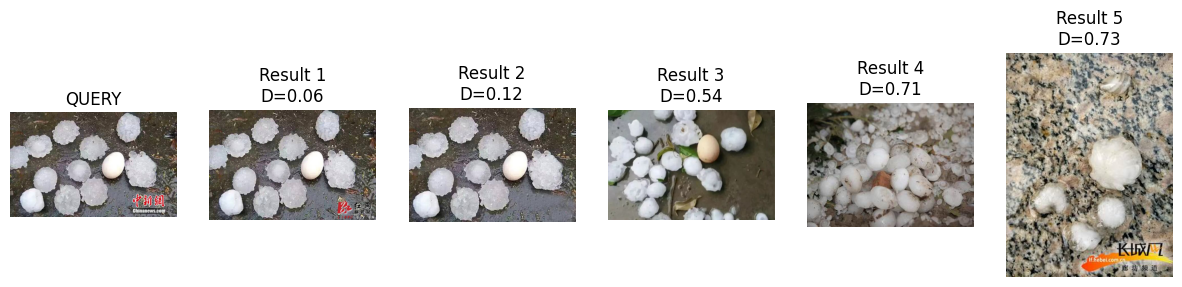

In [ ]:
# --- CONFIGURACIÓN DE LA PRUEBA ---
# Puedes cambiar esto por "CNN_LBP" o "CNN_HSV_LBP" para probar los otros índices
INDEX_NAME = "CNN_HSV_LBP" 
EXTRACTORS = ["CNN", "HSV", "LBP"] 
TOP_K = 5

# 1. Cargar el índice
print(f"📂 Cargando índice: {INDEX_NAME}...")
index, features, db_paths = load_FAISS_index(INDEX_NAME)

if index is None:
    print("❌ Error: No se pudo cargar el índice. Verifica el nombre.")
else:
    # 2. Elegir una imagen aleatoria para usar como "Query" (consulta)
    # Buscamos una imagen real dentro de tu carpeta 'weather'
    clases = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
    clase_random = random.choice(clases)
    dir_imagenes = os.path.join(BASE_DIR, clase_random, "test")
    imagen_random = random.choice(os.listdir(dir_imagenes))
    query_path = os.path.join(dir_imagenes, imagen_random)

    print(f"🔎 Imagen de consulta (Query): {query_path}")

    # 3. Realizar la búsqueda
    distancias, resultados = search_image(query_path, TOP_K, index, db_paths, EXTRACTORS)

    # 4. Mostrar resultados (Texto)
    print("\n🏆 Resultados más parecidos:")
    for i, path_res in enumerate(resultados):
        print(f"   {i+1}. {path_res}  (Distancia: {distancias[i]:.4f})")
    
    # 5. Visualización (Opcional - requiere matplotlib)
    # Si te da error esta parte, es porque falta instalar matplotlib, pero el texto de arriba ya sirve.
    try:
        plt.figure(figsize=(15, 5))
        
        # Mostrar Query
        ax = plt.subplot(1, TOP_K + 1, 1)
        img = mpimg.imread(query_path)
        plt.imshow(img)
        plt.title("QUERY")
        plt.axis("off")

        # Mostrar Resultados
        for i, path_res in enumerate(resultados):
            ax = plt.subplot(1, TOP_K + 1, i + 2)
            img = mpimg.imread(path_res)
            plt.imshow(img)
            plt.title(f"Result {i+1}\nD={distancias[i]:.2f}")
            plt.axis("off")
        
        plt.show()
    except ImportError:
        print("\n(Instala 'matplotlib' si quieres ver las imágenes aquí mismo: pip install matplotlib)")

Evaluando sobre 111 imágenes de test
   > Procesando índice: CNN_HSV...


Eval CNN_HSV: 100%|██████████| 111/111 [00:15<00:00,  7.19it/s]


   > Procesando índice: CNN_LBP...


Eval CNN_LBP: 100%|██████████| 111/111 [00:13<00:00,  8.06it/s]


   > Procesando índice: CNN_HSV_LBP...


Eval CNN_HSV_LBP: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]


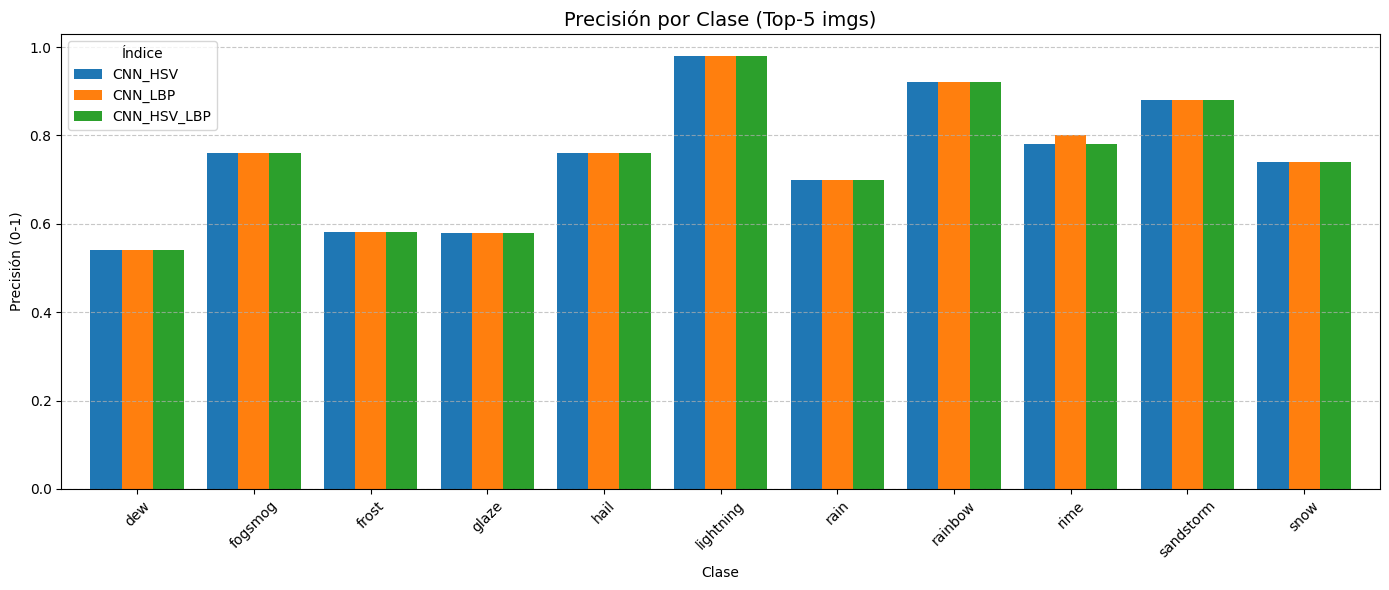

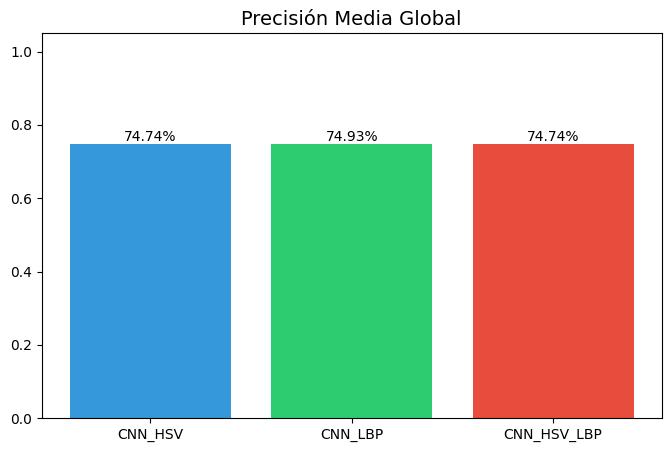

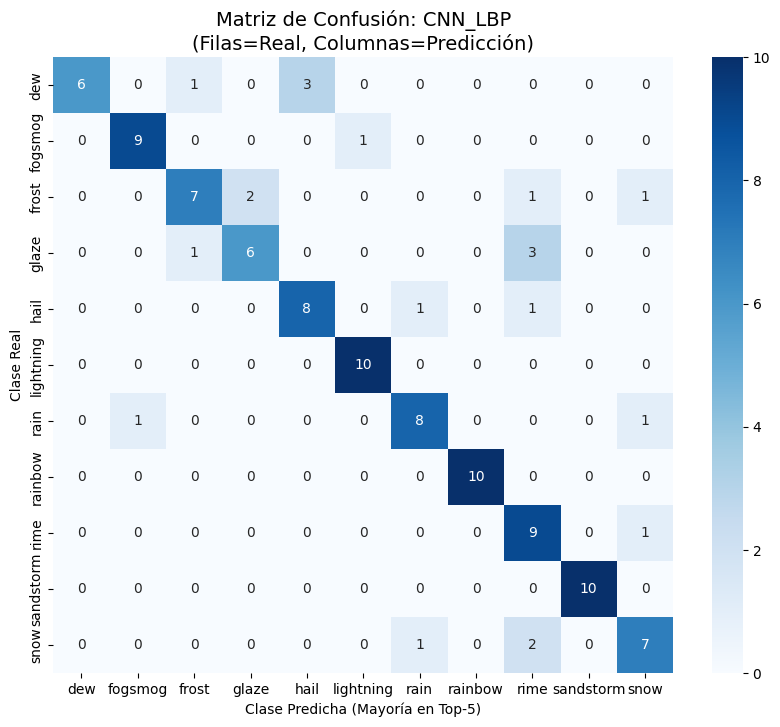

In [13]:
def get_true_class(path):
    """
    Extrae el nombre de la clase de la ruta del archivo
    """
    path = path.replace('\\', '/')
    parts = path.split('/')
    for i, part in enumerate(parts):
        if part in ['train', 'test']:
            return parts[i-1]
    return "unknown"

def evaluate_indices(indices_config, top_k=5):
    """
    Evalúa múltiples índices y devuelve métricas (precisión por clase, precisión media global, matriz de confusión).
    """
    classes = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
    test_files = []
    for cls in classes:
        test_dir = os.path.join(BASE_DIR, cls, "test")
        if os.path.exists(test_dir):
            for f in os.listdir(test_dir):
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    test_files.append({"path": os.path.join(test_dir, f), "class": cls})
    
    print(f"Evaluando sobre {len(test_files)} imágenes de test")
    
    all_results = {} # Guardará la precisión por clase de cada modelo
    confusion_data = {} # Guardará datos para matriz de confusión
    
    for index_name, extractors in indices_config:
        print(f"   > Procesando índice: {index_name}...")
        
        # Cargar índice
        index, _, db_paths = load_FAISS_index(index_name)
        if index is None: continue
            
        y_true = []
        y_pred = [] # Clase mayoritaria en el Top-K
        class_hits = {c: [] for c in classes}
        
        for query in tqdm(test_files, desc=f"Eval {index_name}"):
            # Buscar, search_image devuelve (distancias, rutas)
            _, result_paths = search_image(query['path'], top_k, index, db_paths, extractors)
            
            # Calcular aciertos
            hits = 0
            retrieved_classes = []
            for p in result_paths:
                r_class = get_true_class(p)
                retrieved_classes.append(r_class)
                if r_class == query['class']:
                    hits += 1
            
            # Guardar precisión de esta consulta
            class_hits[query['class']].append(hits / top_k)
            
            # Matriz de confusión
            if retrieved_classes:
                most_common = max(set(retrieved_classes), key=retrieved_classes.count)
                y_true.append(query['class'])
                y_pred.append(most_common)
                
        # Promediar por clase
        all_results[index_name] = {cls: np.mean(accs) if accs else 0 for cls, accs in class_hits.items()}
        confusion_data[index_name] = (y_true, y_pred)
        
    return all_results, confusion_data, classes

# Indices
mis_indices = [
    ("CNN_HSV", ["CNN", "HSV"]),
    ("CNN_LBP", ["CNN", "LBP"]),
    ("CNN_HSV_LBP", ["CNN", "HSV", "LBP"])
]

results, conf_matrices, class_names = evaluate_indices(mis_indices)

# Histograma de Precisión por Clase
df_res = pd.DataFrame(results)
ax = df_res.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title(f'Precisión por Clase (Top-5 imgs)', fontsize=14)
plt.ylabel('Precisión (0-1)')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Índice")
plt.tight_layout()
plt.show()

# Rendimiento Global
mean_scores = df_res.mean()
plt.figure(figsize=(8, 5))
bars = plt.bar(mean_scores.index, mean_scores.values, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Precisión Media Global', fontsize=14)
plt.ylim(0, 1.05)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}', ha='center', va='bottom')
plt.show()

# Matriz de Confusión del mejor modelo
best_model = "CNN_LBP"
if best_model in conf_matrices:
    yt, yp = conf_matrices[best_model]
    cm = confusion_matrix(yt, yp, labels=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión: {best_model}\n(Filas=Real, Columnas=Predicción)', fontsize=14)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha (Mayoría en Top-5)')
    plt.show()